<a href="https://colab.research.google.com/github/adit333/Cats_Vs_Dogs_Convnet/blob/master/california_housing_prices_ch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **California Housing Prices Model**

*This notebook closely follow Ch 2 of Hands On Machine Learning*

We will build a housing model to predict median housing price of a distict in California. The data is from the 1990 census.

In [ ]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

## **Get the Data**

### **Download the Data**

In [ ]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
        with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

### **Take a Look at the Data**

In [ ]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [ ]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [ ]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


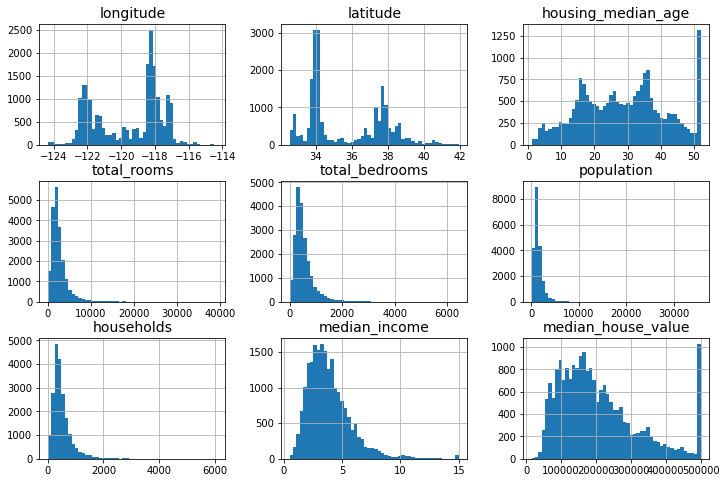

In [ ]:
import matplotlib.pyplot as plt

# extra code – the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

housing.hist(bins=50, figsize=(12, 8))
plt.show()

There are a few things you might notice in these histograms:

1. First, the median income attribute does not look like it is expressed in US dollars (USD). After checking with the team that collected the data, you are told that the data has been scaled and capped at 15 (actually, 15.0001) for higher median incomes, and at 0.5 (actually, 0.4999) for lower median incomes. The numbers represent roughly tens of thousands of dollars (e.g., 3 actually means about $30,000).

2. The housing median age and the median house value were also capped. The latter may be a serious problem since it is your target attribute (your labels).
3. These attributes have very different scales.
4. Finally, many histograms are tail-heavy: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. We will try transforming these attributes later on to have more bell-shaped distributions.

### **Create Test Set**

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [ ]:
len(train_set)

16512

In [ ]:
len(test_set)

4128

##### Stratified Split

Suppose we chatted with experts who told you that the median income is a very important attribute to predict median housing prices. You may want to ensure that the test set is representative of the various categories of incomes in the whole dataset. Since the median income is a continuous numerical attribute, you first need to create an income category attribute. 

Let’s look at the median income histogram more closely: most median income values are clustered around 1.5 to 6 (i.e., $15,000–$60,000), but some median incomes go far beyond 6. It is important to have a sufficient number of instances in your dataset for each stratum, or else the estimate
of a stratum’s importance may be biased. This means that you should not have too many strata, and each stratum should be large enough. The following code uses the pd.cut() function to create an income category attribute with five categories (labeled from 1 to 5): category 1 ranges from 0 to 1.5 (i.e., less than $15,000), category 2 from 1.5 to 3, and so on:

In [ ]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

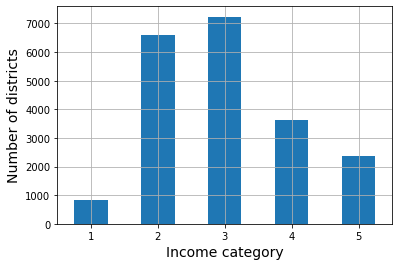

In [ ]:
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(housing, housing["income_cat"]):
    strat_train_set_n = housing.loc[train_index]
    strat_test_set_n = housing.loc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

In [ ]:
strat_train_set, strat_test_set = strat_splits[0]

It's much shorter to get a single stratified split:

In [ ]:
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

## **Discover and Visualize the Data to Gain Insights**

In [ ]:
housing = strat_train_set.copy()

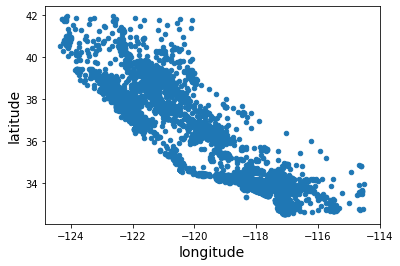

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude")

This looks like California all right, but other than that it is hard to see any particular
pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

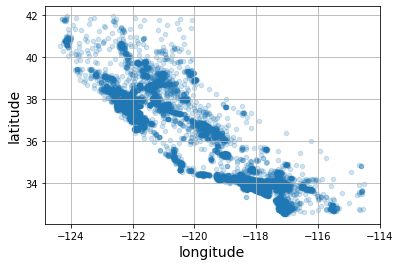

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.2)

Now that’s much better: we can clearly see the high-density areas, namely the Bay Area and around Los Angeles and San Diego, plus a long line of fairly high density in the Central Valley, in particular around Sacramento and Fresno.

Now let’s look at the housing prices. The radius of each circle represents the district’s population (option s), and the color represents the price (option c). We will use a predefined color map (option cmap) called jet, which ranges from blue (low values) to red (high prices)

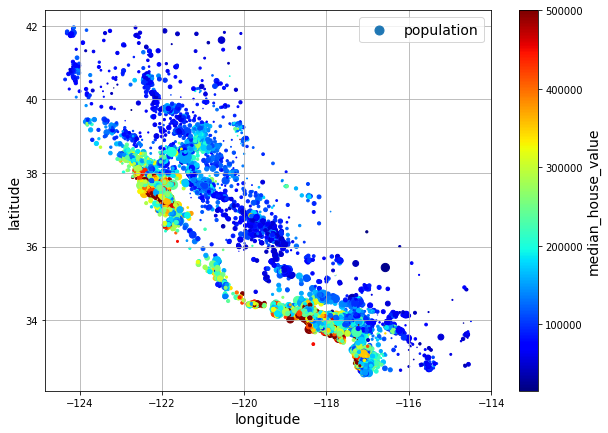

In [ ]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))

This image tells you that the housing prices are very much related to the location
(e.g., close to the ocean) and to the population density

### Looking for Correlations

In [ ]:
corr_matrix = housing.corr()

Now let’s look at how much each attribute correlates with the median house value:

In [ ]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fed2bd08950>,
      dtype=object)

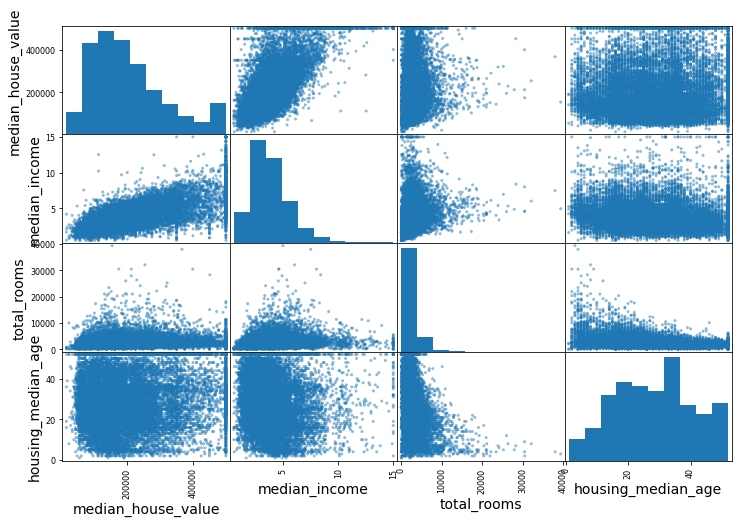

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median income, so let’s zoom in on their correlation scatterplot

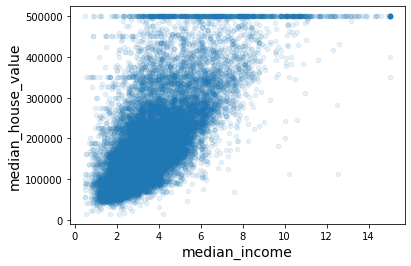

In [ ]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
              alpha=0.1)

This plot reveals a few things. 
1. First, the correlation is indeed very strong; we can clearly see the upward trend, and the points are not too dispersed.

2. Second, a price cap is clearly visible as a horizontal line at 500,000.
But this plot reveals other less obvious straight lines a horizontal line around 450,000, another around 350,000, perhaps one around $280,000, and a few more below that.

### Experimenting with Attribute Combinations

One last thing we may want to do before preparing the data for Machine Learning algorithms is to try out various attribute combinations. For example, the total number of rooms in a district is not very useful if you don’t know how many households there are. What you really want is the number of rooms per household. Similarly, the total number of bedrooms by itself is not very useful: you probably want to compare it to the number of rooms. And the population per household also seems like an interesting attribute combination to look at. Let’s create these new attributes:

In [ ]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"]=housing["population"] / housing["households"]

In [ ]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64

The new bedrooms_per_room attribute is much more correlated with
the median house value than the total number of rooms or bedrooms. Apparently houses with a lower bedroom/room ratio tend to be more expensive. The number of rooms per household is also more informative than the total number of rooms in a district—obviously the larger the houses, the more expensive they are.

## **Prepare the Data for Machine Learning Algorithms**

Let’s revert to a clean training set:

In [ ]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

We saw earlier that the total_bedrooms attribute has some missing values, so let’s fix this by setting the values to the median.

In [ ]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

housing_num = housing.select_dtypes(include=[np.number])    # Choose only numeric columns

imputer.fit(housing_num)

X = imputer.transform(housing_num)

housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing_num.index)

### Handling Text and Categorical Attributes

In this dataset, there is just one text attribute: the ocean_proximity attribute. Let’s look at its value for the first 10 instances:

In [ ]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
13096,NEAR BAY
14973,<1H OCEAN
3785,INLAND
14689,INLAND
20507,NEAR OCEAN
1286,INLAND
18078,<1H OCEAN
4396,NEAR BAY
18031,<1H OCEAN
6753,<1H OCEAN


In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [ ]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [ ]:
sklearn.set_config(display="diagram")

### **Creating a Pipeline**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

Final Clean Pipeline

In [ ]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in 1.0.0."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
      print("Monkey-patching SimpleImputer.get_feature_names_out()")
      SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if self.feature_names_out is None:
                return default_get_feature_names_out(self, names)
            elif callable(self.feature_names_out):
                return self.feature_names_out(names)
            else:
                return self.feature_names_out

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

monkey_patch_get_signature_names_out()

Monkey-patching SimpleImputer.get_feature_names_out()
Monkey-patching FunctionTransformer.get_feature_names_out()


In [ ]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer, make_column_selector

def column_ratio(X):
    return X[:, [0]] / X[:, [1]]

def ratio_pipeline(name=None):
    return make_pipeline(
        SimpleImputer(strategy="median"),
        FunctionTransformer(column_ratio,
                            feature_names_out=[name]),
        StandardScaler())

log_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                             FunctionTransformer(np.log),
                             StandardScaler())

default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                                     StandardScaler())
preprocessing = ColumnTransformer([
        ("bedrooms_ratio", ratio_pipeline("bedrooms_ratio"),
                           ["total_bedrooms", "total_rooms"]),
        ("rooms_per_house", ratio_pipeline("rooms_per_house"),
                            ["total_rooms", "households"]),
        ("people_per_house", ratio_pipeline("people_per_house"),
                             ["population", "households"]),
        ("log", log_pipeline, ["total_bedrooms", "total_rooms",
                               "population", "households", "median_income"]),
        ("cat", cat_pipeline, make_column_selector(dtype_include=object)),
    ],
    remainder=default_num_pipeline)  # one column remaining: housing_median_age

In [ ]:
housing_prepared = preprocessing.fit_transform(housing)
housing_prepared.shape

(16512, 17)

In [ ]:
preprocessing.get_feature_names_out()

array(['bedrooms_ratio__bedrooms_ratio',
       'rooms_per_house__rooms_per_house',
       'people_per_house__people_per_house', 'log__total_bedrooms',
       'log__total_rooms', 'log__population', 'log__households',
       'log__median_income', 'cat__ocean_proximity_<1H OCEAN',
       'cat__ocean_proximity_INLAND', 'cat__ocean_proximity_ISLAND',
       'cat__ocean_proximity_NEAR BAY', 'cat__ocean_proximity_NEAR OCEAN',
       'remainder__longitude', 'remainder__latitude',
       'remainder__housing_median_age', 'remainder__income_cat'],
      dtype=object)

## **Select and Train a Model**

### Training and Evaluating on the Training Set

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       f...
                                                                   StandardScaler())]),
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fed29cad250>)])),
                ('linearregression', LinearRegression())])

Let’s try it out on a few
instances from the training set:

In [ ]:
housing_predictions = lin_reg.predict(housing)
housing_predictions[:5].round(-2)  # -2 = rounded to the nearest hundred

array([264500., 382400., 118100., 106100., 301900.])

In [ ]:
housing_labels.iloc[:5].values

array([458300., 483800., 101700.,  96100., 361800.])

It works, although the predictions are not exactly accurate (e.g., the first prediction is
off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training
set using Scikit-Learn’s mean_squared_error() function:

In [ ]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
lin_rmse

69839.14758388679

This is better than nothing, but clearly not a great score: most districts’ median_housing_values range between $120,000 and $265,000, so a typical prediction error of $68,628 is not very satisfying. This is an example of a model underfitting the training data.

When this happens it can mean that the features do not provide enough information to make good predictions, or that the model is not powerful enough. As we saw in the previous chapter, the main ways to fix underfitting are to select a more powerful model, to feed the training algorithm with better features, or to reduce the constraints on the model. This model is not regularized, which rules out the last option. Let’s try a more complex model to see how it does.

Let’s train a DecisionTreeRegressor. This is a powerful model, capable of finding complex nonlinear relationships in the data

In [ ]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = make_pipeline(preprocessing, DecisionTreeRegressor(random_state=42))
tree_reg.fit(housing, housing_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('bedrooms_ratio',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=['bedrooms_ratio'],
                                                                                       f...
                                                  ['total_bedrooms',
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fed29cad250>)])),
                ('decisiontreeregressor',
                 DecisionTreeRegressor(random_state=42))])

Now that the model is trained, let’s evaluate it on the training set:

In [ ]:
housing_predictions = tree_reg.predict(housing)
tree_rmse = mean_squared_error(housing_labels, housing_predictions,
                              squared=False)
tree_rmse

0.0

Wait, what!? No error at all? Could this model really be absolutely perfect? Of course, it is much more likely that the model has badly overfit the data. How can you be sure?

### Better Evaluation Using Cross-Validation

In [ ]:
from sklearn.model_selection import cross_val_score

tree_rmses = -cross_val_score(tree_reg, housing, housing_labels,
                              scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(tree_rmses).describe()

count       10.000000
mean     69655.157213
std       1946.929569
min      65614.135917
25%      68773.666920
50%      69807.364418
75%      70857.683316
max      72374.310672
dtype: float64

Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform
worse than the Linear Regression model!

In [ ]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = make_pipeline(preprocessing,
                           RandomForestRegressor(random_state=42))
forest_rmses = -cross_val_score(forest_reg, housing, housing_labels,
                                scoring="neg_root_mean_squared_error", cv=10)

In [ ]:
pd.Series(forest_rmses).describe()

count       10.000000
mean     49640.592715
std       1068.890758
min      47554.492819
25%      49060.460699
50%      49844.100488
75%      50168.082452
max      51267.407703
dtype: float64

Wow, this is much better: Random Forests look very promising. However, note that
the score on the training set is still much lower than on the validation sets, meaning
that the model is still overfitting the training set.

### **Fine-Tune Your Model**

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
  {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
  {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                scoring='neg_mean_squared_error',
                return_train_score=True)

grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [ ]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [ ]:
grid_search.best_estimator_

### Analyze the Best Models and Their Errors

The RandomForestRegressor can indicate the relative importance of each
attribute for making accurate predictions:

In [ ]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [ ]:
feature_importances

array([5.26237727e-02, 4.26048383e-02, 1.04208152e-01, 1.73094079e-02,
       1.81483760e-02, 1.86478463e-02, 1.70835898e-02, 2.93955004e-01,
       1.40355788e-02, 1.25595413e-01, 1.81489073e-04, 2.85636325e-03,
       5.56782042e-03, 7.02287453e-02, 5.90647441e-02, 4.39918561e-02,
       1.13897003e-01])

In [ ]:
sorted(zip(feature_importances,
           preprocessing.get_feature_names_out()),
           reverse=True)

[(0.29395500362880317, 'log__median_income'),
 (0.12559541295557602, 'cat__ocean_proximity_INLAND'),
 (0.11389700335294038, 'remainder__income_cat'),
 (0.10420815200170512, 'people_per_house__people_per_house'),
 (0.07022874531796822, 'remainder__longitude'),
 (0.059064744135049876, 'remainder__latitude'),
 (0.05262377265103317, 'bedrooms_ratio__bedrooms_ratio'),
 (0.04399185612268096, 'remainder__housing_median_age'),
 (0.04260483831075695, 'rooms_per_house__rooms_per_house'),
 (0.01864784629530895, 'log__population'),
 (0.01814837598571319, 'log__total_rooms'),
 (0.0173094079142781, 'log__total_bedrooms'),
 (0.01708358979561308, 'log__households'),
 (0.014035578785022587, 'cat__ocean_proximity_<1H OCEAN'),
 (0.005567820423350239, 'cat__ocean_proximity_NEAR OCEAN'),
 (0.0028563632511522923, 'cat__ocean_proximity_NEAR BAY'),
 (0.00018148907304765588, 'cat__ocean_proximity_ISLAND')]

### Evaluate Your System on the Test Set

In [ ]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

final_model = grid_search.best_estimator_

X_test_prepared = preprocessing.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(final_rmse)

50653.817663034926


95% confidence interval:

In [ ]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

array([48269.09024252, 52931.21399363])